In [1]:
# Moment analysis
import os
import time
import yaml  # Saving results
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp  # CAS for exact matrix inverison
from matplotlib.backends.backend_pdf import PdfPages

# Inline plotting
%matplotlib inline

# Dir where simulations are in
sim_dir = os.path.abspath('/home/leloup/ownCloud/simulations/statistics/')

# Dir where plots are saved into
plot_dir = os.path.abspath('/home/leloup/Desktop/Uni/Master/p760_computational_physics/git/analysis/moment_analysis/plots')

In [2]:
# Get required prefix
def get_prefix(dim, l):
    """Returns required prefix"""
    return 'x'.join(str(l) for _ in range(dim))

# Function to load data of first and second moment which is going to be bootstrapped
def load_data(dim, model, observable, crit_slope=None):
    """Loads first and second moment data of observable of dim dimensions of model"""
    # Our lattice lengths are from 10 to 100
    lattices = np.arange(10, 110, 10)
    
    # 10 simulations per length
    n_samples = 10
    
    # Result matrices for 1st and second moment data
    moment1_data = np.zeros(shape=(n_samples, len(lattices)))
    moment2_data = np.zeros(shape=(n_samples, len(lattices)))
    
    for col, length in enumerate(lattices):
        sim_files = os.listdir(sim_dir)
        n_file = 0
        i = 0
        while n_file < n_samples:
            f = sim_files[i % len(sim_files)]
            if f.endswith('.npy'):
                tmp = f.split('.')[0].split('_')
                prefix = tmp[0]
                tmp_n = tmp[-1]
                tmp_model = tmp[-2]
                
                if tmp_model=='custom' and crit_slope is not None:
                    slope_flag = crit_slope == int(tmp[tmp.index('slope') + 1])
                else:
                    slope_flag = True

                if get_prefix(dim, length) == prefix and model==tmp_model and tmp_n==str(n_file) and slope_flag:
                    
                    # Load data
                    tmp_data = np.load(os.path.join(sim_dir, f))
                    
                    # Get observable
                    tmp_data = tmp_data[observable]
                    
                    # Moments
                    tmp_moment1 = np.log(np.mean(tmp_data))
                    tmp_moment2 = np.log(np.mean(np.power(tmp_data, 2)))
                    
                    # Write to reults
                    moment1_data[n_file, col] = tmp_moment1
                    moment2_data[n_file, col] = tmp_moment2
                    
                    # Increase file counter
                    n_file += 1
                    
            # Increase loop counter
            i+=1
    return moment1_data, moment2_data

In [3]:
def bootstrap_fit(moment1_data, moment2_data, n_bootstraps):
    """Bootstrap fitting of first and second moment data via frozen covariance approach"""
    
    # Number of samples
    n_samples = moment1_data.shape[0]
    
    # Length of samples
    l_samples = moment1_data.shape[1]
    sample_idx = np.arange(l_samples)
    
    # Bootstrap matrices
    bootstrapped_means_mom1 = np.zeros(shape=(n_bootstraps, l_samples))
    bootstrapped_means_mom2 = np.zeros(shape=(n_bootstraps, l_samples))
    
    # Do bootstrapping
    for k in range(n_bootstraps):
        
        # Bootstrap random idx with replacement
        rand_idx1 = tuple(np.random.choice(sample_idx, size=l_samples, replace=True))
        rand_idx2 = tuple(np.random.choice(sample_idx, size=l_samples, replace=True))
        
        # Bootstrab entire data at once using same random idx
        bootstrap_sample_mom1 = moment1_data[rand_idx1, :]
        bootstrap_sample_mom2 = moment2_data[rand_idx2, :]
        
        # Take bootstrap mean column wise for one row at once
        bootstrapped_means_mom1[k,:] = np.mean(bootstrap_sample_mom1, axis=0)
        bootstrapped_means_mom2[k,:] = np.mean(bootstrap_sample_mom2, axis=0)
        
    # Bootstrap indices
    bootstrap_idx = np.arange(n_bootstraps)
    
    # Make mean matrix of bootstraped means
    mean_bootstraps_mom1 = np.zeros_like(bootstrapped_means_mom1)
    mean_bootstraps_mom2 = np.zeros_like(bootstrapped_means_mom2)
    
    # Fill mean matrix row wise with same rows of means
    mean_bootstraps_mom1[tuple(bootstrap_idx), :] = np.mean(bootstrapped_means_mom1, axis=0)
    mean_bootstraps_mom2[tuple(bootstrap_idx), :] = np.mean(bootstrapped_means_mom2, axis=0)
    
    # Diff between sampled means and overall means
    mean_diff_mom1 = bootstrapped_means_mom1 - mean_bootstraps_mom1
    mean_diff_mom2 = bootstrapped_means_mom2 - mean_bootstraps_mom2
    
    # Make covariance matrices
    cov_mat_mom1 = np.zeros(shape=(n_samples, n_samples))
    cov_mat_mom2 = np.zeros(shape=(n_samples, n_samples))
    
    # Fill covariance matrices
    for i in range(n_samples):
        for j in range(n_samples):
            cov_mat_mom1[i, j] = np.mean(mean_diff_mom1[:, i] * mean_diff_mom1[:, j])
            cov_mat_mom2[i, j] = np.mean(mean_diff_mom2[:, i] * mean_diff_mom2[:, j])
    
    cov_mat_mom1 = sp.Matrix(cov_mat_mom1)
    cov_mat_mom2 = sp.Matrix(cov_mat_mom2)
    cov_mat_inv1 = cov_mat_mom1.inv()
    cov_mat_inv2 = cov_mat_mom2.inv()
    
    cov_mat_inv1 = np.array(cov_mat_inv1).astype(np.float64)
    cov_mat_inv2 = np.array(cov_mat_inv2).astype(np.float64)
    
    # X fit values
    L = np.log(np.arange(10, 110, 10))
    
    # Z matrix
    z_mat = np.ones(shape=(n_samples, 2))
    z_mat[:,1] = L
    
    tmp1 = np.matmul(np.matmul(z_mat.T, cov_mat_inv1), z_mat)
    tmp2 = np.matmul(np.matmul(z_mat.T, cov_mat_inv2), z_mat)
    
    tmp1 = sp.Matrix(tmp1)
    tmp2 = sp.Matrix(tmp2)
    
    tmp_mat_mom1 = tmp1.inv()#np.linalg.inv(tmp1)
    tmp_mat_mom2 = tmp2.inv()#np.linalg.inv(tmp2)
    
    tmp_mat_mom1 = np.array(tmp_mat_mom1).astype(np.float64)
    tmp_mat_mom2 = np.array(tmp_mat_mom2).astype(np.float64)
    
    T_mat_mom1 = np.matmul(np.matmul(tmp_mat_mom1, z_mat.T), cov_mat_inv1)
    T_mat_mom2 = np.matmul(np.matmul(tmp_mat_mom2, z_mat.T), cov_mat_inv2)
    
    # Actual bootstrap fitting
    T_beta1 = np.zeros(shape=(n_bootstraps, 2))
    T_beta2 = np.zeros(shape=(n_bootstraps, 2))
    
    # Bootstrap matrices
    bootstrapped_means_mom1 = np.zeros(shape=(n_bootstraps, l_samples))
    bootstrapped_means_mom2 = np.zeros(shape=(n_bootstraps, l_samples))
    
    # Do bootstrapping
    for k in range(n_bootstraps):
        
        # Bootstrap random idx with replacement
        rand_idx1 = tuple(np.random.choice(sample_idx, size=l_samples, replace=True))
        rand_idx2 = tuple(np.random.choice(sample_idx, size=l_samples, replace=True))
        
        # Bootstrab entire data at once using same random idx
        bootstrap_sample_mom1 = moment1_data[rand_idx1, :]
        bootstrap_sample_mom2 = moment2_data[rand_idx2, :]
        
        # Take bootstrap mean column wise for one row at once
        bootstrapped_means_mom1[k,:] = np.mean(bootstrap_sample_mom1, axis=0)
        bootstrapped_means_mom2[k,:] = np.mean(bootstrap_sample_mom2, axis=0)
    
    # Linear regression
    for k in range(n_bootstraps):
        T_beta1[k, :] = np.matmul(T_mat_mom1, bootstrapped_means_mom1[k, :])
        T_beta2[k, :] = np.matmul(T_mat_mom2, bootstrapped_means_mom2[k, :])
        
    # Calculate critical exponent, observable dimension D
    def tau(sigma1, sigma2):
        return 3.0 - sigma2/(sigma2-sigma1)
    
    def D(sigma1, sigma2):
        return sigma2 - sigma1
    
    # Results all bootstrap samples for critical exponent and observable dimension 
    bootstrap_critical_exponent = np.zeros(shape=n_bootstraps)
    bootstrap_dim_exponent = np.zeros(shape=n_bootstraps)
    
    for k in range(n_bootstraps):
        bootstrap_critical_exponent[k] = tau(T_beta1[k, 1], T_beta2[k, 1])
        bootstrap_dim_exponent[k] = D(T_beta1[k, 1], T_beta2[k, 1])
    
    final_critical_exponent = np.array([np.mean(bootstrap_critical_exponent), np.std(bootstrap_critical_exponent)])
    final_dim_exponent = np.array([np.mean(bootstrap_dim_exponent), np.std(bootstrap_dim_exponent)])
    final_logA1 = np.array([np.mean(T_beta1[:, 0]), np.std(T_beta1[:, 0])])
    final_sigma1 = np.array([np.mean(T_beta1[:, 1]), np.std(T_beta1[:, 1])])
    final_logA2 = np.array([np.mean(T_beta2[:, 0]), np.std(T_beta2[:, 0])])
    final_sigma2 = np.array([np.mean(T_beta2[:, 1]), np.std(T_beta2[:, 1])])
    
    return_dict = {'critical_exponent': final_critical_exponent, 'dim_exponent': final_dim_exponent, 'logA1': final_logA1,'logA2': final_logA2,
                   'sigma1': final_sigma1, 'sigma2': final_sigma2}
    
    return return_dict

In [4]:
def double_bootstrap_fit(moment1_data, moment2_data, n_bootstraps, n_inner):
    """Bootstrap fitting of first and second moment data via double bootstrap approach"""
    
    # Number of samples
    n_samples = moment1_data.shape[0]
    
    # Length of samples
    l_samples = moment1_data.shape[1]
    sample_idx = np.arange(l_samples)
    
    # Inner bootstrap indices
    bootstrap_idx = np.arange(n_inner)
    
    # Static matrices needed for fitting
    # X fit values
    L = np.log(np.arange(10, 110, 10))

    # Z matrix
    z_mat = np.ones(shape=(n_samples, 2))
    z_mat[:,1] = L
    
    # Store fit parameters of first and second moment fits
    T_beta1 = np.zeros(shape=(n_bootstraps, 2))
    T_beta2 = np.zeros(shape=(n_bootstraps, 2))
    
    # Do outer bootstrapping
    for k in range(n_bootstraps):
        
        # Bootstrap random idx with replacement
        rand_idx1 = tuple(np.random.choice(sample_idx, size=l_samples, replace=True))
        rand_idx2 = tuple(np.random.choice(sample_idx, size=l_samples, replace=True))
        
        # Bootstrab entire data at once using same random idx
        bootstrap_sample_mom1 = moment1_data[rand_idx1, :]
        bootstrap_sample_mom2 = moment2_data[rand_idx2, :]
        
        # Double bootstrap matrices
        bootstrapped_means_mom1 = np.zeros(shape=(n_inner, l_samples))
        bootstrapped_means_mom2 = np.zeros(shape=(n_inner, l_samples))
        
        # Do double bootstrapping for outer bootstrap
        for l in range(n_inner):

            # Bootstrap random idx with replacement
            tmp_rand_idx1 = tuple(np.random.choice(sample_idx, size=l_samples, replace=True))
            tmp_rand_idx2 = tuple(np.random.choice(sample_idx, size=l_samples, replace=True))

            # Bootstrab entire data at once using same random idx
            tmp_bootstrap_sample_mom1 = bootstrap_sample_mom1[tmp_rand_idx1, :]
            tmp_bootstrap_sample_mom2 = bootstrap_sample_mom2[tmp_rand_idx2, :]

            # Take bootstrap mean column wise for one row at once
            bootstrapped_means_mom1[l,:] = np.mean(tmp_bootstrap_sample_mom1, axis=0)
            bootstrapped_means_mom2[l,:] = np.mean(tmp_bootstrap_sample_mom2, axis=0)

        # Make mean matrix of bootstrapped means
        tmp_mean_bootstraps_mom1 = np.zeros_like(bootstrapped_means_mom1)
        tmp_mean_bootstraps_mom2 = np.zeros_like(bootstrapped_means_mom2)

        # Fill mean matrix row wise with same rows of means
        tmp_mean_bootstraps_mom1[tuple(bootstrap_idx), :] = np.mean(bootstrapped_means_mom1, axis=0)
        tmp_mean_bootstraps_mom2[tuple(bootstrap_idx), :] = np.mean(bootstrapped_means_mom2, axis=0)

        # Diff between sampled means and overall means
        tmp_mean_diff_mom1 = bootstrapped_means_mom1 - tmp_mean_bootstraps_mom1
        tmp_mean_diff_mom2 = bootstrapped_means_mom2 - tmp_mean_bootstraps_mom2

        # Make covariance matrices
        tmp_cov_mat_mom1 = np.zeros(shape=(n_samples, n_samples))
        tmp_cov_mat_mom2 = np.zeros(shape=(n_samples, n_samples))

        # Fill covariance matrices of double bootstrap
        for i in range(n_samples):
            for j in range(n_samples):
                tmp_cov_mat_mom1[i, j] = np.mean(tmp_mean_diff_mom1[:, i] * tmp_mean_diff_mom1[:, j])
                tmp_cov_mat_mom2[i, j] = np.mean(tmp_mean_diff_mom2[:, i] * tmp_mean_diff_mom2[:, j])
        
        # Use sympy CAS in order to calculate the exact inverse of matrices
        # Convert matrices from numpy to sympy matrices
        tmp_cov_mat_mom1 = sp.Matrix(tmp_cov_mat_mom1)
        tmp_cov_mat_mom2 = sp.Matrix(tmp_cov_mat_mom2)
        
        # Invert matrices
        tmp_cov_mat_inv1 = tmp_cov_mat_mom1.inv()
        tmp_cov_mat_inv2 = tmp_cov_mat_mom2.inv()
        
        # Convert back to numpy arrays
        tmp_cov_mat_inv1 = np.array(tmp_cov_mat_inv1).astype(np.float64)
        tmp_cov_mat_inv2 = np.array(tmp_cov_mat_inv2).astype(np.float64)
        
        # Calculate temporary matrices which need to be inverted as well
        tmp1 = np.matmul(np.matmul(z_mat.T, tmp_cov_mat_inv1), z_mat)
        tmp2 = np.matmul(np.matmul(z_mat.T, tmp_cov_mat_inv2), z_mat)
        
        # Convert matrices from numpy to sympy matrices
        tmp1 = sp.Matrix(tmp1)
        tmp2 = sp.Matrix(tmp2)
        
        # Invert matrices
        tmp_mat_mom1 = tmp1.inv()
        tmp_mat_mom2 = tmp2.inv()
        
        # Convert back to numpy arrays
        tmp_mat_mom1 = np.array(tmp_mat_mom1).astype(np.float64)
        tmp_mat_mom2 = np.array(tmp_mat_mom2).astype(np.float64)
        
        # Calculate T matrix which is needed for calculating fit parameters
        T_mat_mom1 = np.matmul(np.matmul(tmp_mat_mom1, z_mat.T), tmp_cov_mat_inv1)
        T_mat_mom2 = np.matmul(np.matmul(tmp_mat_mom2, z_mat.T), tmp_cov_mat_inv2)
        
        # Linear regression
        T_beta1[k, :] = np.matmul(T_mat_mom1, np.mean(bootstrap_sample_mom1, axis=0))
        T_beta2[k, :] = np.matmul(T_mat_mom2, np.mean(bootstrap_sample_mom2, axis=0))
        
    # Calculate critical exponent, observable dimension D
    def tau(sigma1, sigma2):
        return 3.0 - sigma2/(sigma2-sigma1)
    
    def D(sigma1, sigma2):
        return sigma2 - sigma1
    
    # Results all bootstrap samples for critical exponent and observable dimension 
    bootstrap_critical_exponent = np.zeros(shape=n_bootstraps)
    bootstrap_dim_exponent = np.zeros(shape=n_bootstraps)
    
    for k in range(n_bootstraps):
        bootstrap_critical_exponent[k] = tau(T_beta1[k, 1], T_beta2[k, 1])
        bootstrap_dim_exponent[k] = D(T_beta1[k, 1], T_beta2[k, 1])
    
    final_critical_exponent = np.array([np.mean(bootstrap_critical_exponent), np.std(bootstrap_critical_exponent)])
    final_dim_exponent = np.array([np.mean(bootstrap_dim_exponent), np.std(bootstrap_dim_exponent)])
    final_logA1 = np.array([np.mean(T_beta1[:, 0]), np.std(T_beta1[:, 0])])
    final_sigma1 = np.array([np.mean(T_beta1[:, 1]), np.std(T_beta1[:, 1])])
    final_logA2 = np.array([np.mean(T_beta2[:, 0]), np.std(T_beta2[:, 0])])
    final_sigma2 = np.array([np.mean(T_beta2[:, 1]), np.std(T_beta2[:, 1])])
    
    return_dict = {'critical_exponent': final_critical_exponent, 'dim_exponent': final_dim_exponent, 'logA1': final_logA1,'logA2': final_logA2,
                   'sigma1': final_sigma1, 'sigma2': final_sigma2}
    
    return return_dict

In [ ]:
### Basically this is the main ###

results = {'duration': {}, 'size': {}, 'area': {}}
n_bootstraps = 40  # Rule of thumb: n_bootstraps = 4 * n_samples
n_inner = 20000 # Number of double bootstraps
n_fits = 100  # Number of fits
dim = 2
model = 'custom'
crit_slope = 7
# Do n_fits in order to get the quantities with minimum uncertainty for all extracted quantities
for i in range(n_fits):
    # Feedback
    print '===Fit %i===' % i
    
    # Make temporary result
    tmp_results = {'duration': None, 'size': None, 'area': None}
    
    # Loop over observables
    for observable in tmp_results.keys():
        
        # Load first and second moment from data
        mom1, mom2 = load_data(dim, model, observable, crit_slope=crit_slope)
        
        # Try doing bootstrap fits; ValueError occurs if some matrix is not invertable
        try:
            # Do double bootstrap fit for observable's moments
            tmp_results[observable] = double_bootstrap_fit(mom1, mom2, n_bootstraps, n_inner)
            
            # Loop over extraction quantities and write tmp results to final result dict;
            # Convert everything to floats in order to safe to file
            for key in tmp_results[observable].keys():
                
                # First iteration of n_fits: initialize values in result dict
                if key not in results[observable]:
                    results[observable][key] = []
                    for j in range(len(tmp_results[observable][key])):
                        results[observable][key].append(float(tmp_results[observable][key][j]))
                
                # Overwrite if lower deviation on quantity has been achieved within this fit
                elif tmp_results[observable][key][1] < results[observable][key][1]:
                    for j in range(len(tmp_results[observable][key])):
                        results[observable][key][j] = float(tmp_results[observable][key][j])
        
        # Matrix inversion failed
        except ValueError:
            print 'Skipped'
            continue

# Safe results
model_str = model if model == 'btw' else model + '_crit_slope_%i' % crit_slope
with open('results%id_%s.yaml' % (dim, model_str), 'w') as f:
    yaml.safe_dump(results, stream=f, default_flow_style=False)


In [45]:
with open('n_bootstraps_40_n_inner_20000/results3d_btw.yaml', 'r') as f:
    results = yaml.safe_load(f)
dim=3
model='btw'
crit_slope=7
print results

{'duration': {'dim_exponent': [1.4149740384038103, 0.0559014384603214], 'critical_exponent': [1.4538242720207226, 0.02769079677825407], 'sigma1': [0.7690147340840314, 0.014565192459095608], 'logA1': [-1.5924220265700513, 0.056789639306772374], 'logA2': [-2.194557200252886, 0.12624179887352963], 'sigma2': [2.1842041529029403, 0.03337476459884264]}, 'area': {'dim_exponent': [2.5900276909870614, 0.7119089345734876], 'critical_exponent': [1.4231698980027736, 0.29226755687548495], 'sigma1': [1.610655063177024, 0.1160196842066689], 'logA1': [-1.5361073047079448, 0.3739038715572823], 'logA2': [-2.275251370875721, 2.2138723120370627], 'sigma2': [4.191695182517597, 0.6988857366926224]}, 'size': {'dim_exponent': [2.548610252874179, 0.3318132146874306], 'critical_exponent': [1.2592965742016946, 0.1297207689158107], 'sigma1': [1.8204805200703067, 0.09337385668128803], 'logA1': [-3.0711322530508545, 0.32842192572928236], 'logA2': [-4.58789488609961, 1.1600349890172124], 'sigma2': [4.397435480917925

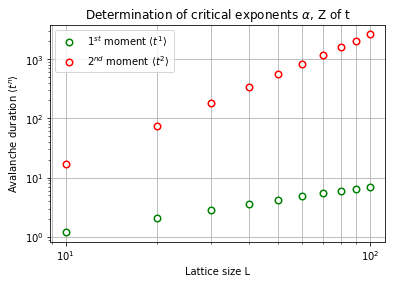

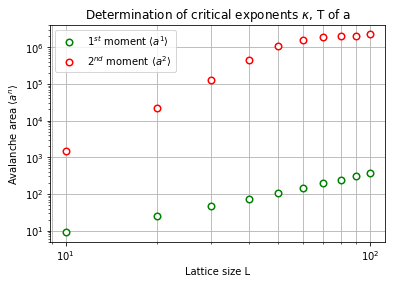

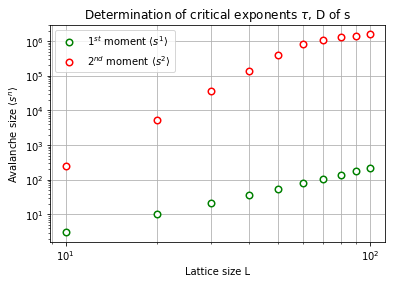

In [47]:
def fit(x, a, b):
    return np.exp(a) * np.power(x, b)
# Critical exponents:
# Avalanche size exponent tau; avalanche dimension D
# Avalanche duration exponent alpha; dynamic exponent z
# D,z and tau, aplha are STANDARD SET OF SOC EXPONENTS of a SOC model (page 22 SOC book)
# Avalanche area exponent lambda; f
critical_exponents = {'duration': [r'$\alpha$', 'Z'], 'size': [r'$\tau$', 'D'], 'area': [r'$\kappa$', 'T']}
va = {'duration': 't', 'size': 's', 'area': 'a'}
x = np.arange(10,110,10)
for field in results.keys():
    mom1, mom2 = load_data(dim, model, field)
    res = results[field]
    ce = critical_exponents[field]
    #plt.plot(x, np.exp(np.mean(mom1, axis=0)),c='g', label=r'$ 1^{st}\ \mathrm{moment}\ \left< %s^1 \right>$' % va[field], marker='o', ms=6.5, mfc='w', zorder=10, mew=1.5)
    #plt.plot(x, np.exp(np.mean(mom2, axis=0)),c='r', label=r'$ 2^{nd}\ \mathrm{moment}\ \left< %s^2 \right>$' % va[field], marker='o', ms=6.5, mfc='w', zorder=10, mew=1.5)
    plt.plot(x, np.exp(np.mean(mom1, axis=0)), ls='None',c='g', label=r'$ 1^{st}\ \mathrm{moment}\ \left< %s^1 \right>$' % va[field], marker='o', ms=6.5, mfc='w', zorder=10, mew=1.5)
    plt.plot(x, np.exp(np.mean(mom2, axis=0)), ls='None',c='r', label=r'$ 2^{nd}\ \mathrm{moment}\ \left< %s^2 \right>$' % va[field], marker='o', ms=6.5, mfc='w', zorder=10, mew=1.5)
    #plt.plot(x, fit(x, res['logA1'][0], res['sigma1'][0]), c='g', ls='--', label=r'Linear fit $\left< %s^1 \right>$' % va[field])
    #plt.plot(x, fit(x, res['logA2'][0], res['sigma2'][0]), c='r', ls='--', label=r'Linear fit $\left< %s^2 \right>$' % va[field])
    plt.title(r'Determination of critical exponents %s, %s of %s' % (ce[0], ce[1], va[field]))
    plt.xlabel('Lattice size L')
    plt.ylabel(r'Avalanche %s $\left< %s^n \right>$' % (field, va[field]))
    plt.loglog()
    plt.grid(which='both', axis='x')
    plt.grid(which='major', axis='y')
    plt.legend()
    model_str = model if model == 'btw' else model + '_crit_slope_%i' % crit_slope
    out = os.path.join(plot_dir, 'moment_analysis_%s_%id_%s.pdf' % (field, dim, model_str))
    plt.savefig(out)
    plt.show()